In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller


file_path = "C:\\Users\\Student\\Downloads\\ambika_internships\\Data reports\\Kalman\\ICBK_1to6_2020.csv"
df = pd.read_csv(file_path)
df.head(), df.dtypes

(         Date   Price    Open    High    Low    Vol. Change %
 0  30-06-2020  351.45  347.00  354.45  346.3  47.53M    2.43%
 1  29-06-2020  343.10  345.25  345.60  338.5  27.39M   -1.72%
 2  26-06-2020  349.10  355.60  358.50  346.1  34.60M   -0.54%
 3  25-06-2020  351.00  345.90  355.60  338.5  69.91M    0.83%
 4  24-06-2020  348.10  380.00  380.00  345.0  57.96M   -7.46%,
 Date         object
 Price       float64
 Open        float64
 High        float64
 Low         float64
 Vol.         object
 Change %     object
 dtype: object)

In [21]:
# Converting 'Date' to datetime format and sorting by ascending order
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')

# Clean 'Vol.': remove 'M' (millions) and convert to numeric
df['Volume'] = df['Vol.'].str.replace('M', '').astype(float) * 1e6

# Clean 'Change %': remove '%' and convert to float
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Keep only Price and Volume which is useful for time series
df_clean = df[['Price', 'Volume', 'Change %']]

df_clean.head()

,Price,Volume,Change %
Date,,,
2020-01-01,536.75,7640000.0,-0.40
2020-01-02,540.60,10260000.0,0.72
2020-01-03,538.85,9590000.0,-0.32
2020-01-06,525.70,12530000.0,-2.44
2020-01-07,522.90,16100000.0,-0.53


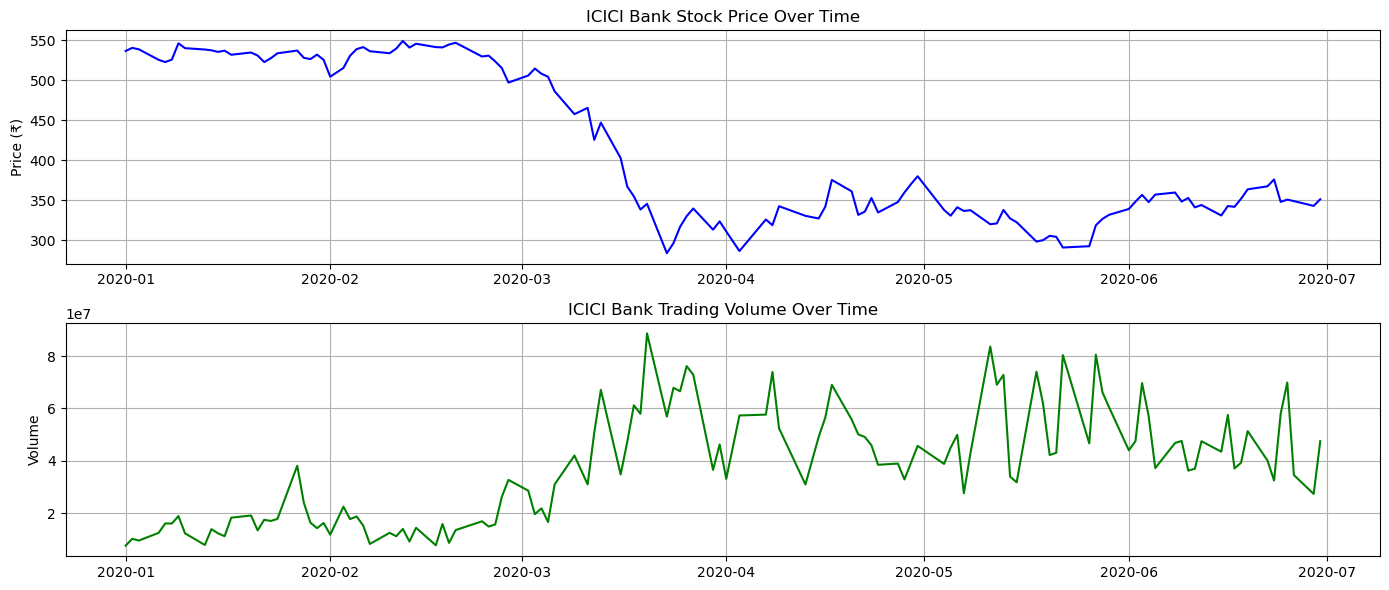

In [23]:
#plotting stock price and volume over time
plt.figure(figsize=(14, 6))

# Price plot
plt.subplot(2, 1, 1)
plt.plot(df_clean.index, df_clean['Price'], label='Price', color='blue')
plt.title('ICICI Bank Stock Price Over Time')
plt.ylabel('Price (₹)')
plt.grid(True)

# Volume plot
plt.subplot(2, 1, 2)
plt.plot(df_clean.index, df_clean['Volume'], label='Volume', color='green')
plt.title('ICICI Bank Trading Volume Over Time')
plt.ylabel('Volume')
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
df_arima = df[['Price']].copy()

# Step 1: Check stationarity with ADF(Augmented Dickey-Fuller) test
adf_result = adfuller(df_arima['Price'])

# If non-stationary, take first difference
if adf_result[1] > 0.05:
    df_arima['Price_diff'] = df_arima['Price'].diff().dropna()
    data_for_model = df_arima['Price_diff'].dropna()
    d = 1
else:
    data_for_model = df_arima['Price']
    d = 0

# Step 2: Fit ARIMA model
model = ARIMA(data_for_model, order=(5, d, 2))  
model_fit = model.fit()

# Step 3: Forecast the next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# If differencing was applied, revert forecast to original scale
if d == 1:
    last_price = df_arima['Price'].iloc[-1]
    forecast = forecast.cumsum() + last_price
forecast_dates = pd.date_range(start=df_arima.index[-1], periods=forecast_steps+1, freq='B')[1:]
forecast_series = pd.Series(forecast.values, index=forecast_dates)
forecast_series.head()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\a

2020-07-01    339.735936
2020-07-02    343.728696
2020-07-03    339.595119
2020-07-06    338.039149
2020-07-07    339.293083
Freq: B, dtype: float64

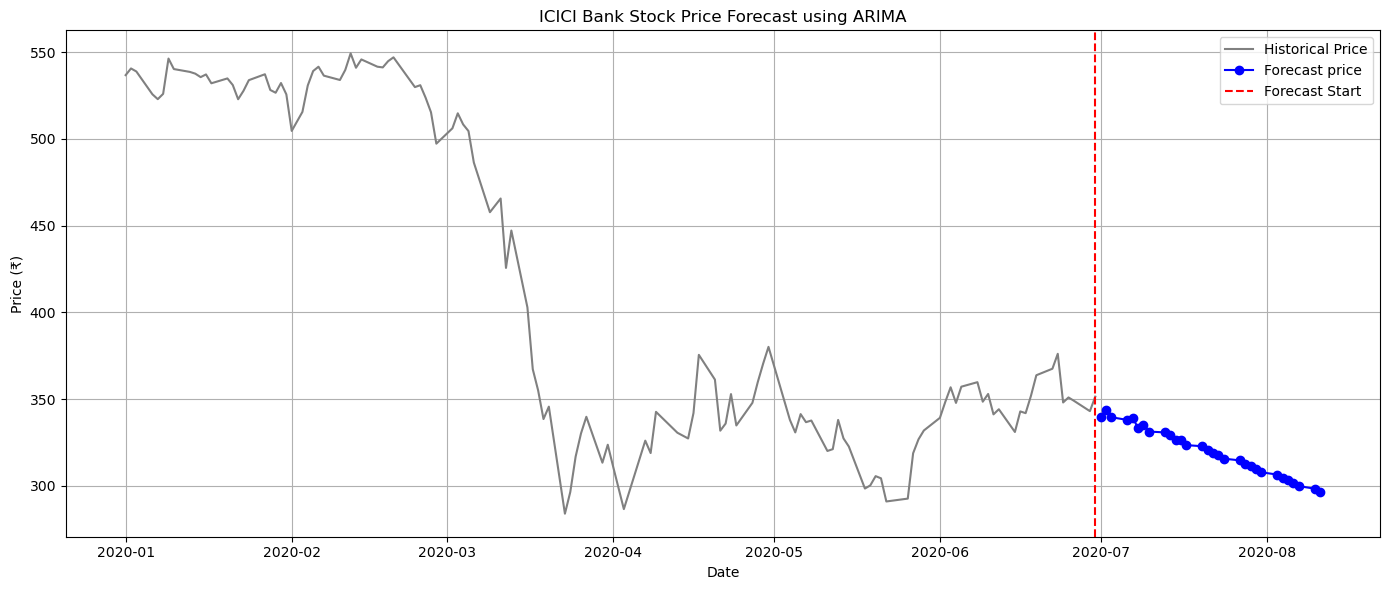

In [31]:
# Plotting the original price data and the forecasted values

plt.figure(figsize=(14, 6))
plt.plot(df_arima['Price'], label='Historical Price', color='gray')
plt.plot(forecast_series, label='Forecast price', color='blue', marker='o')
plt.axvline(df_arima.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ICICI Bank Stock Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()